<a href="https://colab.research.google.com/github/MarkLimmage/AustralianSharePrices/blob/main/MA5851_A2_Mark_Limmage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import json
import csv
from io import StringIO
from bs4 import BeautifulSoup
import requests
import pandas as pd
from tqdm.notebook import tqdm

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
allords = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MA5851/assessments/A2/allords.csv', encoding = "ISO-8859-1"))
allords

,code,company
0,360,LIFE360 Inc
1,3DP,Pointerra Ltd
2,A200,Betashares Australia 200 ETF
3,A2M,The a2 Milk Company Ltd
4,A4N,Alpha Hpa Ltd
...,...,...
493,XRO,Xero Ltd
494,YAL,Yancoal Australia Ltd
495,Z1P,ZIP Co Ltd
496,ZEL,Z Energy Ltd


In [ ]:
company_url = 'https://au.finance.yahoo.com/quote/{}?p={}'
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36' }

soup = dict()

articles = pd.DataFrame( columns=['company', 'article_url', 'pub_time'])
errors = pd.DataFrame( columns=['company', 'script'] )
for index, row in tqdm(allords.iterrows(), total=allords.shape[0]):
  company = str(row['code']) + '.AX'
  json_key = str('YFINANCE:'+ company + '.mega')
  page = company_url.format(company,company)
  response = requests.get(page, headers=headers)
  soup = BeautifulSoup(response.text, 'html.parser')
  pattern = re.compile(r'\s--\sData\s--\s')
  script_data=soup.find('script', text=pattern).contents[0]
  company_page = json.loads(script_data[112:-12])
  try:  
    items = company_page['context']['dispatcher']['stores']['StreamStore']['streams'][json_key]['data']['stream_items']
    for item in items:
      try:
        # print(company, item['url'], item['pubtime'])
        articles = articles.append({'company':company, 'article_url':item['url'], 'pub_time':item['pubtime']}, ignore_index = True)
      except:
        pass
  except Exception as e: 
    errors = errors.append({'company':company, 'script':company_page}, ignore_index=True)
      



100%|██████████| 498/498 [14:30<00:00,  1.75s/it]


In [ ]:
# Save this to disk so we don't have to run the query again (~10 min)
articles.to_csv('/content/drive/MyDrive/Colab Notebooks/MA5851/assessments/A2/articles.csv')
errors.to_csv('/content/drive/MyDrive/Colab Notebooks/MA5851/assessments/A2/errors.csv')

In [ ]:
articles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MA5851/assessments/A2/articles.csv')
errors = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MA5851/assessments/A2/errors.csv')

In [ ]:
print('stocks:', len(allords), ' | ', 'articles:',articles.shape[0],' | ', 'errors:', errors.shape[0])

stocks: 498  |  articles: 2958  |  errors: 35


In [ ]:
articles

,Unnamed: 0,company,article_url,pub_time
0,0,360.AX,https://au.finance.yahoo.com/news/type-shareho...,1660082471000
1,1,360.AX,https://au.finance.yahoo.com/news/life360-asx-...,1655347315000
2,2,360.AX,https://au.finance.yahoo.com/news/life360-asx-...,1651457394000
3,3,360.AX,https://au.finance.yahoo.com/news/au-5-90-life...,1648799910000
4,4,360.AX,https://au.finance.yahoo.com/news/apple-google...,1647522008000
...,...,...,...,...
2953,2953,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1652240144000
2954,2954,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1646801023000
2955,2955,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1642047389000
2956,2956,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1637199612000


In [ ]:

headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36' }

soup = dict()
article_errors = list()

articles['story'] = ''
article_errors = pd.DataFrame( columns=['article', 'script'] )
for index, row in tqdm(articles.iterrows(), total=articles.shape[0]):
  page = row['article_url']
  response = requests.get(page, headers=headers)
  soup = BeautifulSoup(response.text, 'html.parser')
  try:  
    article_div=soup.find_all('div', class_='caas-body')[0]
    articles.loc[index, 'story'] = str(article_div)[23:-7]
  except Exception as e: 
    article_errors.append([index])

100%|██████████| 2958/2958 [42:05<00:00,  1.17it/s]


In [ ]:
articles.shape

(2958, 5)

In [ ]:
articles.to_csv('/content/drive/MyDrive/Colab Notebooks/MA5851/assessments/A2/stories.csv')

In [ ]:
stories = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MA5851/assessments/A2/stories.csv')

In [ ]:
stories = articles

In [ ]:
stories

,Unnamed: 0,Unnamed: 0.1,company,article_url,pub_time,story
0,0,0,360.AX,https://au.finance.yahoo.com/news/type-shareho...,1660082471000,<p>If you want to know who really controls Lif...
1,1,1,360.AX,https://au.finance.yahoo.com/news/life360-asx-...,1655347315000,"<p>Warren Buffett famously said, 'Volatility i..."
2,2,2,360.AX,https://au.finance.yahoo.com/news/life360-asx-...,1651457394000,<p>The simplest way to benefit from a rising m...
3,3,3,360.AX,https://au.finance.yahoo.com/news/au-5-90-life...,1648799910000,"<p>Life360, Inc. (<a class=""link "" data-ylk=""s..."
4,4,4,360.AX,https://au.finance.yahoo.com/news/apple-google...,1647522008000,<p>(Bloomberg) -- A push in Congress to regula...
...,...,...,...,...,...,...
2953,2953,2953,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1652240144000,<p>Zimplats Holdings' (ASX:ZIM) stock is up by...
2954,2954,2954,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1646801023000,<p>What are the early trends we should look fo...
2955,2955,2955,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1642047389000,"<p>When you buy shares in a company, it's wort..."
2956,2956,2956,ZIM.AX,https://au.finance.yahoo.com/news/zimplats-hol...,1637199612000,<p>Zimplats Holdings' (ASX:ZIM) stock is up by...


In [ ]:
from platform import python_version
print(python_version())

3.7.13


In [ ]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

def remove_by_regex(texts, regexp):
        output_texts = regexp.sub("",texts)
        return output_texts
    
def remove_urls(input_text):
        return remove_by_regex(input_text, re.compile(r"http.?://[^\s]+[\s]?"))
    
def text_preprocessing(uncleaned_text):  
    review = cleanhtml(str(uncleaned_text))  
    review = re.sub('[^a-zA-Z0-9]', ' ', review)
    review = review.lower()
    review = remove_urls(review)
    review = review.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    return review

    

In [ ]:
stories['clean_story'] = stories['story'].apply(lambda x: text_preprocessing(x) )

In [ ]:
stories['clean_story']

0       want know realli control life360 inc asx 360 l...
1       warren buffett famous said volatil far synonym...
2       simplest way benefit rise market buy index fun...
3       life360 inc asx 360 might not larg cap stock r...
4       bloomberg push congress regul digit app store ...
                              ...                        
2953    zimplat hold asx zim stock consider 21 past th...
2954    earli trend look identifi stock could multipli...
2955    buy share compani worth keep mind possibl coul...
2956    zimplat hold asx zim stock consider 17 past th...
2957    trend look want identifi stock multipli valu l...
Name: clean_story, Length: 2958, dtype: object

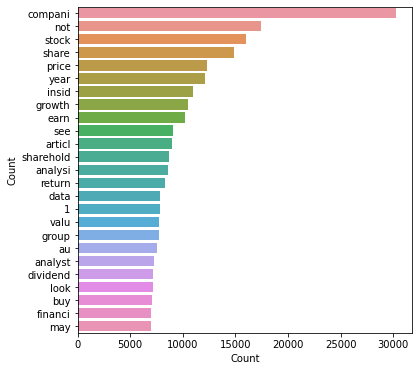

In [ ]:

corpus = list()
all_words = ' '.join([text for text in stories['clean_story']]) 
all_words = all_words.split() 

all_words = nltk.FreqDist(all_words)

# create dataframe
all_words_df = pd.DataFrame({'Category': list(all_words.keys()), 
                              'Count': list(all_words.values())})
g = all_words_df.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(6,6)) 
ax = sns.barplot(data=g, x= "Count", y = "Category") 
ax.set(ylabel = 'Count') 
plt.show()

In [ ]:
all_words_df

,Category,Count
0,want,1785
1,know,1892
2,realli,674
3,control,574
4,life360,89
...,...,...
26227,483m,1
26228,711m,1
26229,797m,1
26230,rocezimplat,1


In [ ]:


for c_story in stories['clean_story']:
  corpus = corpus + 

corpus = set(corpus)

wtokens = nltk.word_tokenize(str(corpus))
print(len(wtokens))     # Number of words in text 

fdist = nltk.FreqDist(corpus)


143


In [ ]:
corpus

{' ',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

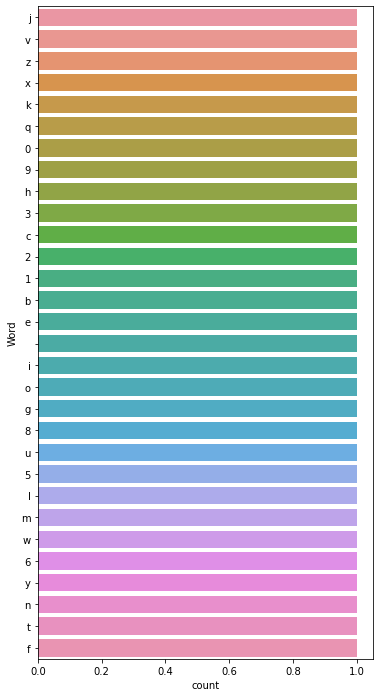

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def freq_words(x, terms = 30): 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(6,12)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
freq_words(wtokens)

In [ ]:
print('Processed:', len(list(fdist.keys())), ' | Raw:', len(corpus))

Processed: 26815  | Raw: 2910
